# Shortcut Analysis in SNLI

This notebook identifies and quantifies the lexical and structural shortcuts
that allow a hypothesis-only model to achieve 71% accuracy on SNLI (vs. 33% chance).

It relies on `src.analysis.shortcut_statistics` for all computation.
Pre-computed caches in `results/shortcut_analysis/data/` are loaded when available.

See `experiments/exp_03_shortcut_analysis.md` for the full report.

In [1]:
import sys, json
from pathlib import Path

# Detect repo root regardless of repo name or Jupyter launch directory
ROOT = next(p for p in [Path().resolve(), *Path().resolve().parents] if (p / '.git').exists())
sys.path.insert(0, str(ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from transformers import AutoTokenizer

import src.analysis.shortcut_statistics as ss
from src.data.standard import preprocess_dataset

DATA_DIR = ROOT / 'results/shortcut_analysis/data'
FIG_DIR  = ROOT / 'results/shortcut_analysis/figures'
DATA_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

DATASET_NAME = 'stanfordnlp/snli'
MODEL_NAME   = 'bert-base-uncased'
COLORS = {'entailment': '#4CAF50', 'neutral': '#FFC107', 'contradiction': '#F44336'}

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f'ROOT: {ROOT}')
print('OK')

ROOT: /workspace
OK


## Setup

We work with the **Stanford NLI (SNLI)** training set (~550k premise–hypothesis pairs, three-way
classification: entailment / neutral / contradiction).

The core observation motivating this analysis is that a model trained on the *hypothesis alone*
(no premise) achieves **~71% accuracy** on the SNLI validation set — far above the 33% chance
baseline. This implies the hypotheses carry label-predictive signals that a model can exploit
without reading the premise at all. We call these signals *shortcuts* or *annotation artifacts*.

This notebook quantifies them along two axes:

1. **Lexical shortcuts** — individual tokens whose presence in the hypothesis strongly predicts a particular label (measured via *lift*).
2. **Structural shortcuts** — surface-level features such as hypothesis length and premise–hypothesis token overlap that differ systematically across labels.

Finally, we run both models (pair-input vs. hypothesis-only) on the validation set and measure how their accuracy correlates with shortcut strength.

## 1. Lexical shortcuts (lift)

**Lift** is a simple association measure borrowed from market-basket analysis:

$$\text{lift}(t, \ell) = \frac{P(\ell \mid t)}{P(\ell)}$$

A lift of 1.0 means the token $t$ is no more predictive of label $\ell$ than the base rate.
A lift of 2.0 means a hypothesis containing $t$ is twice as likely to have label $\ell$ as a
randomly drawn example. We apply a minimum count threshold (100 occurrences) and remove
common stopwords before computing lifts, retaining only tokens that are both frequent enough to
be statistically reliable and content-bearing enough to be potentially informative.

In [2]:
# Load lift scores from cache, or recompute from scratch.
cache_lift = DATA_DIR / 'lift_scores.csv'
cache_counts = DATA_DIR / 'token_label_counts.json'

if cache_lift.exists():
    lift_df = pd.read_csv(cache_lift)
    print(f'Loaded lift_scores.csv ({lift_df["token"].nunique():,} tokens)')
else:
    # Need token-label counts first
    if cache_counts.exists():
        with open(cache_counts) as f:
            token_label_counts = json.load(f)
        print(f'Loaded token_label_counts.json ({len(token_label_counts):,} tokens)')
    else:
        dataset = preprocess_dataset(DATASET_NAME, split='train')
        token_label_counts = ss.compute_token_label_counts(dataset, tokenizer)
        with open(cache_counts, 'w') as f:
            json.dump(token_label_counts, f, indent=2)
        print(f'Computed and saved token_label_counts.json ({len(token_label_counts):,} tokens)')

    lift_df = ss.compute_lift(token_label_counts)
    lift_df.to_csv(cache_lift, index=False)
    print(f'Computed and saved lift_scores.csv ({lift_df["token"].nunique():,} tokens)')

Loaded lift_scores.csv (2,362 tokens)


In [3]:
# Top 10 shortcuts per label
top = ss.top_shortcuts(lift_df, top_k=10)

for label in ss.LABEL_NAMES:
    print(f'\n── {label.upper()} ──')
    print(f'{"token":20s}  {"lift":>6}  {"P(l|t)":>8}  {"count":>7}')
    print('─' * 46)
    for _, r in top[label].iterrows():
        print(f'{r["token"]:20s}  {r["lift"]:6.2f}  {r["p_label_given_token"]:8.2%}  {int(r["count"]):7,}')


── ENTAILMENT ──
token                   lift    P(l|t)    count
──────────────────────────────────────────────
least                   3.08    92.53%      359
interacting             2.90    87.18%      136
motion                  2.83    85.00%      102
outdoors                2.62    78.80%    5,076
physical                2.61    78.51%       95
canine                  2.58    77.69%       94
multiple                2.53    76.19%      256
sport                   2.49    74.76%      397
instrument              2.47    74.43%      949
touching                2.47    74.42%      352

── NEUTRAL ──
token                   lift    P(l|t)    count
──────────────────────────────────────────────
##ously                 2.66    97.77%      175
impress                 2.63    96.34%      184
championship            2.59    95.00%      342
siblings                2.54    93.15%      272
belongs                 2.51    92.00%       92
paid                    2.47    90.57%      144
charity  

### Interpretation

The top tokens reveal clear thematic clusters that reflect SNLI's annotation process:

- **Entailment** shortcuts are mostly **paraphrase or subsumption cues** — words like *outdoors*, *canine*, *sport*, *instrument*, *touching* — all of which describe the same situation as the premise at a more specific or equivalent level. A crowdworker asked to write a true statement about a scene naturally reaches for concrete descriptors that are entailed by the premise.
- **Neutral** shortcuts are dominated by **inference-introducing terms** — *championship*, *vacation*, *upcoming*, *siblings*, *winning* — hypotheses that *could* be true but go beyond what the premise establishes. The suffix *##ously* captures long adverbs (e.g., "impressively") often used in speculative neutral sentences.
- **Contradiction** shortcuts are the most semantically coherent: **negation and impossibility markers** — *nobody*, *nothing*, *silent*, *cats* (often appearing as "the cats are sleeping" contradicting action scenes). These tokens have the highest lifts (up to 3.0×) and collectively explain much of the hypothesis-only model's predictive power.

The lift scores above 2.5× indicate that these tokens alone provide a very strong prior — a model that simply memorizes these associations can perform well above chance.

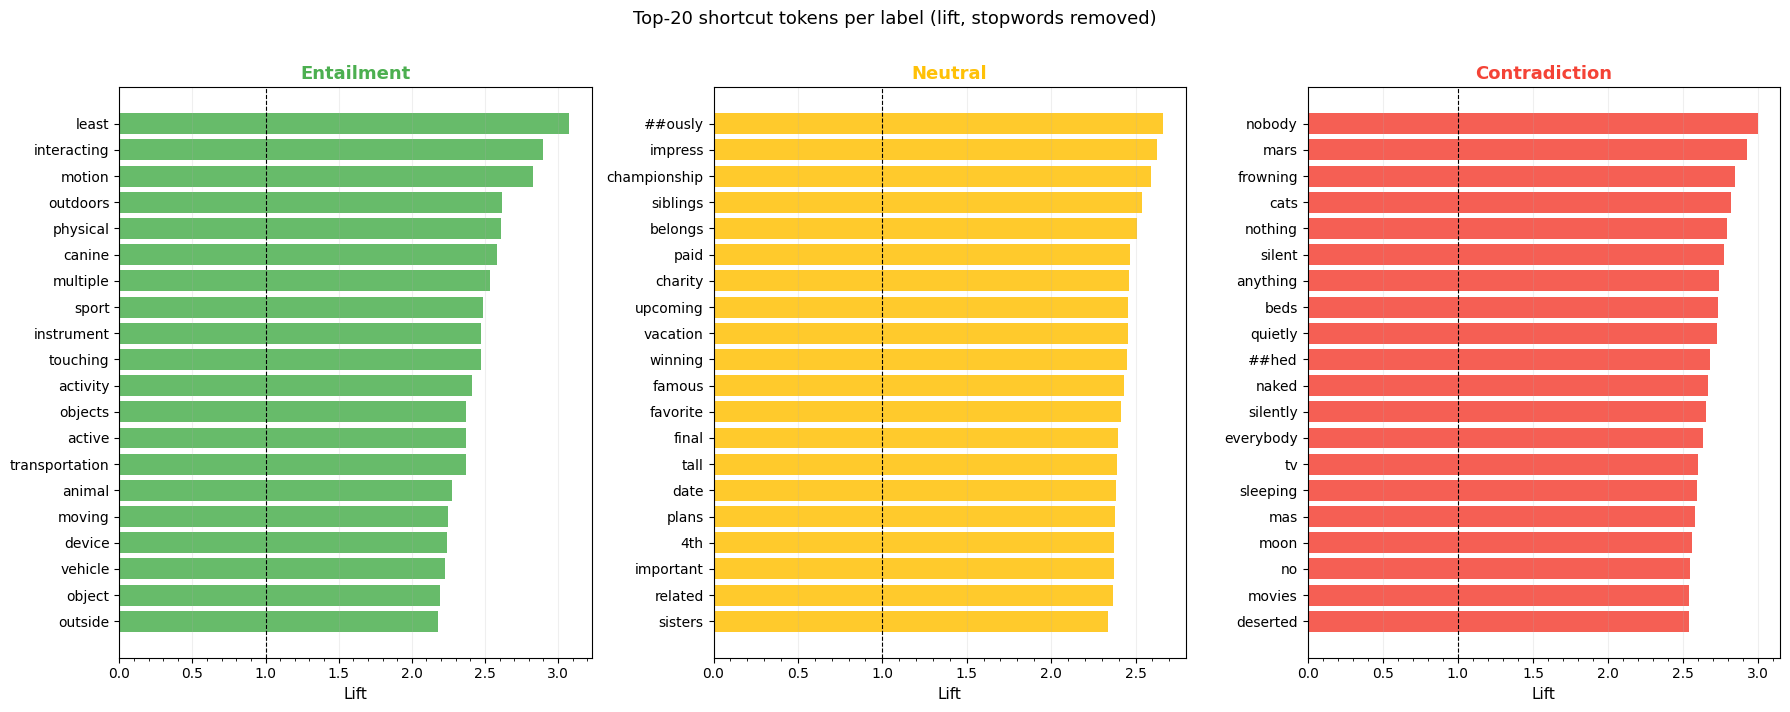

In [4]:
# Figure: top-20 tokens by lift per label
TOP_K = 20

fig, axes = plt.subplots(1, 3, figsize=(18, 7), sharey=False)
for ax, label in zip(axes, ss.LABEL_NAMES):
    sub = (
        lift_df[lift_df['label'] == label]
        .sort_values('lift', ascending=False)
        .head(TOP_K)
        .iloc[::-1]
    )
    ax.barh(sub['token'], sub['lift'], color=COLORS[label], alpha=0.85)
    ax.axvline(1.0, color='black', linewidth=0.8, linestyle='--', label='chance')
    ax.set_xlabel('Lift', fontsize=11)
    ax.set_title(label.capitalize(), fontsize=13, fontweight='bold', color=COLORS[label])
    ax.xaxis.set_minor_locator(mticker.AutoMinorLocator())
    ax.grid(axis='x', alpha=0.2)

fig.suptitle(f'Top-{TOP_K} shortcut tokens per label (lift, stopwords removed)', fontsize=13, y=1.01)
plt.tight_layout()
plt.savefig(FIG_DIR / 'lift_per_label.png', dpi=150, bbox_inches='tight')
plt.show()

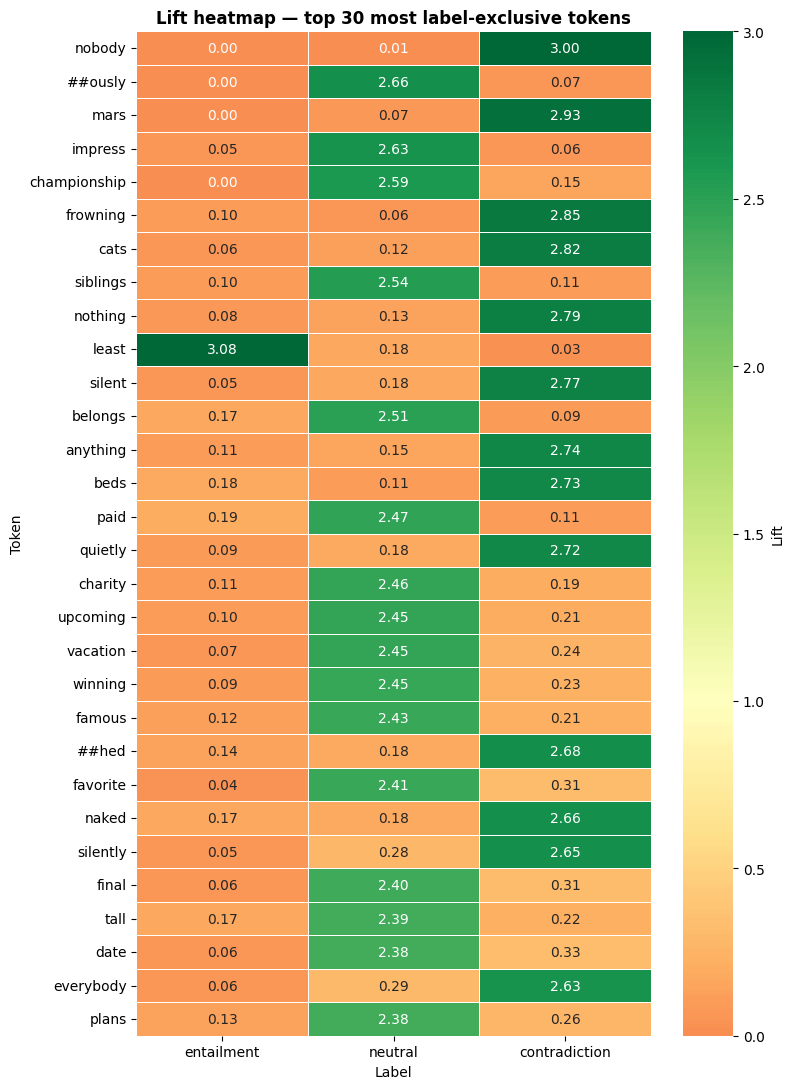

In [5]:
# Figure: lift heatmap for the 30 most concentrated tokens
N_HEATMAP = 30
top_tokens = (
    lift_df.drop_duplicates('token')
    .sort_values('concentration', ascending=False)
    .head(N_HEATMAP)['token'].tolist()
)
heat = (
    lift_df[lift_df['token'].isin(top_tokens)]
    .pivot(index='token', columns='label', values='lift')
    .loc[top_tokens, ss.LABEL_NAMES]
)

fig, ax = plt.subplots(figsize=(8, 11))
sns.heatmap(heat, annot=True, fmt='.2f', cmap='RdYlGn', center=1.0,
            vmin=0, vmax=3, linewidths=0.4, cbar_kws={'label': 'Lift'}, ax=ax)
ax.set_title(f'Lift heatmap — top {N_HEATMAP} most label-exclusive tokens', fontsize=12, fontweight='bold')
ax.set_xlabel('Label'); ax.set_ylabel('Token')
plt.tight_layout()
plt.savefig(FIG_DIR / 'lift_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

The bar charts confirm that shortcut tokens are **label-exclusive**: the highest-lift tokens for one label tend to have near-baseline lift for the other two. The heatmap makes this even clearer — tokens in the upper rows show a single dominant green cell (high lift) and two red cells (below-baseline for the other labels), indicating they are strongly associated with exactly one label.

This label exclusivity is what makes these tokens useful as shortcuts: encountering *nobody* in a hypothesis is almost a sufficient condition for predicting *contradiction* (P ≈ 99.5%), regardless of the premise.

## 2. Structural shortcuts

Beyond individual token choices, there are **surface structural patterns** that differ across labels. These arise from the same annotation artifact: crowdworkers writing entailments tend to rephrase the premise closely (high overlap), while those writing contradictions introduce new concepts (lower overlap, often with negation tokens already captured above).

We compute four features per example:
- **`hyp_len`** — number of unique BERT tokens in the hypothesis (after removing special tokens).
- **`overlap_count`** — number of tokens shared between premise and hypothesis.
- **`overlap_ratio`** — `overlap_count / hyp_len`, normalized for hypothesis length.
- **`jaccard`** — `overlap_count / |premise ∪ hypothesis|`, a symmetric similarity measure.

A logistic regression trained on these four features alone gives us a model-free estimate of how much label information is encoded in surface structure.

In [6]:
# Load structural features from cache, or recompute.
cache_path = DATA_DIR / 'structural_features.csv'

if cache_path.exists():
    struct_df = pd.read_csv(cache_path)
    print(f'Loaded structural_features.csv ({len(struct_df):,} rows)')
else:
    dataset = preprocess_dataset(DATASET_NAME, split='train')
    struct_df = ss.compute_structural_features(dataset, tokenizer)
    struct_df.to_csv(cache_path, index=False)
    print(f'Computed and saved structural_features.csv ({len(struct_df):,} rows)')

Structural features: 100%|██████████| 549367/549367 [00:58<00:00, 9441.22it/s] 


Computed and saved structural_features.csv (549,367 rows)


In [7]:
# Descriptive statistics
for feat in ['hyp_len', 'overlap_ratio', 'jaccard']:
    print(f'\n── {feat} ──')
    for label in ss.LABEL_NAMES:
        sub = struct_df[struct_df['label'] == label][feat]
        print(f'  {label:15s}  mean={sub.mean():.3f}  std={sub.std():.3f}')


── hyp_len ──
  entailment       mean=7.296  std=2.631
  neutral          mean=8.931  std=3.293
  contradiction    mean=8.072  std=2.788

── overlap_ratio ──
  entailment       mean=0.618  std=0.228
  neutral          mean=0.472  std=0.195
  contradiction    mean=0.438  std=0.201

── jaccard ──
  entailment       mean=0.312  std=0.179
  neutral          mean=0.259  std=0.167
  contradiction    mean=0.220  std=0.150


### Interpretation

The statistics show consistent, label-ordered patterns:

- **Hypothesis length**: Neutral hypotheses are the longest on average (8.9 tokens), followed by contradiction (8.1) and entailment (7.3). Entailments are shorter because they tend to restate the premise in fewer words; neutral hypotheses often introduce additional context.
- **Overlap ratio**: Entailment hypotheses share ~61.8% of their tokens with the premise, versus ~43.8% for contradictions. This makes intuitive sense — an entailment paraphrases or specializes the premise, while a contradiction replaces content with its negation or opposite.
- **Jaccard similarity**: The same gradient holds, confirming the trend is not an artifact of length differences.

These differences are statistically reliable across 550k examples and, crucially, are observable from the *hypothesis alone* (length) or from the *pair* but without any semantic understanding (overlap).

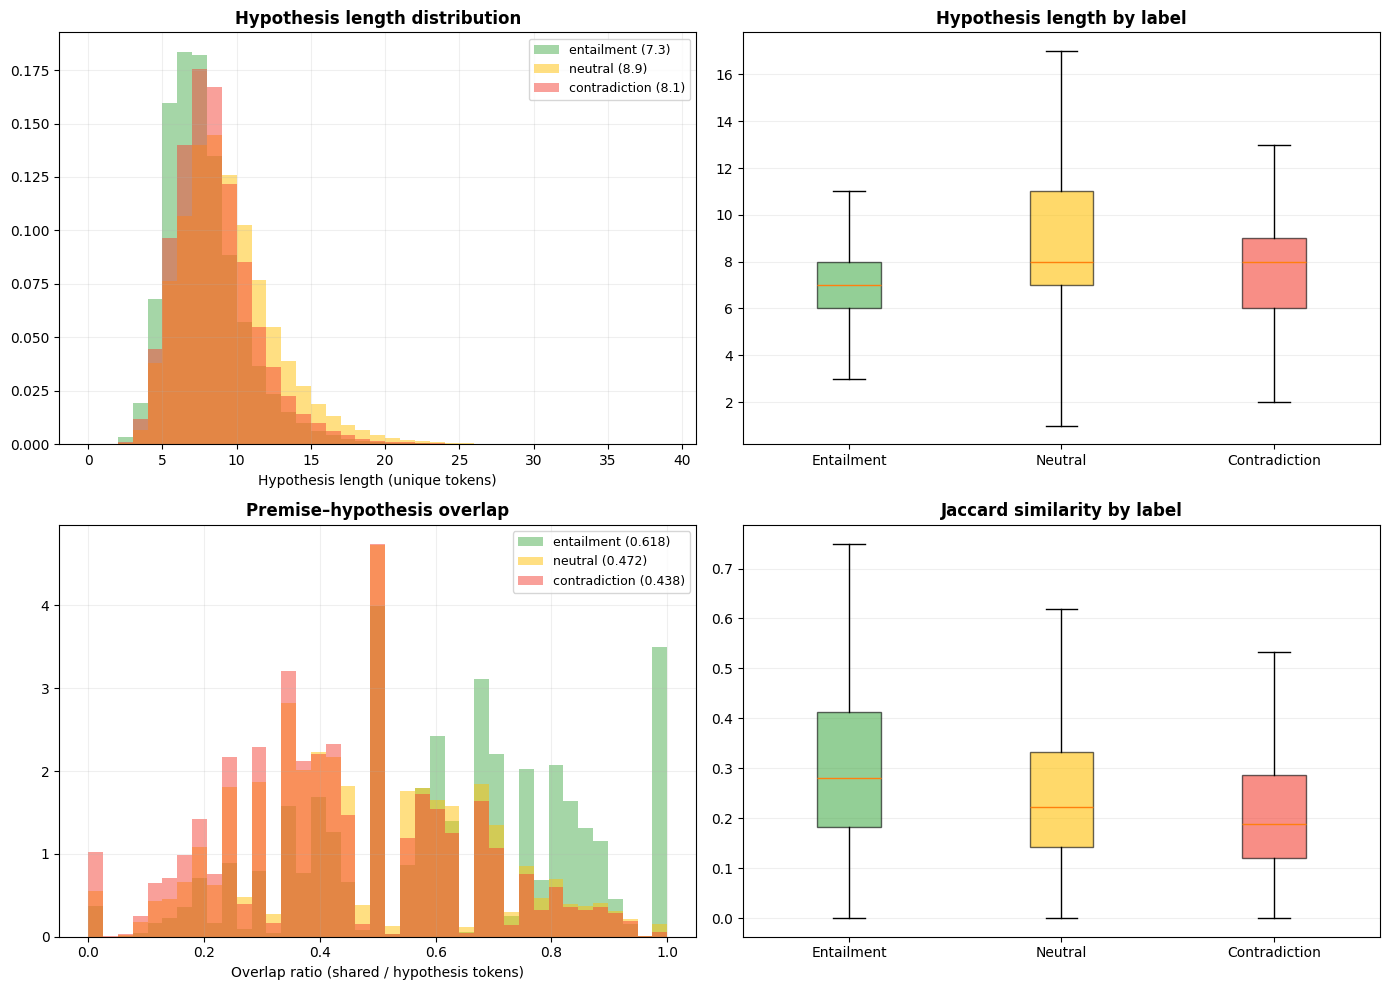

In [8]:
# Figure: length + overlap distributions (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: hypothesis length histograms
ax = axes[0, 0]
for label in ss.LABEL_NAMES:
    sub = struct_df[struct_df['label'] == label]['hyp_len']
    ax.hist(sub, bins=range(0, 40), alpha=0.5, density=True,
            label=f'{label} ({sub.mean():.1f})', color=COLORS[label])
ax.set_xlabel('Hypothesis length (unique tokens)')
ax.set_title('Hypothesis length distribution', fontweight='bold')
ax.legend(fontsize=9); ax.grid(alpha=0.2)

# Top-right: length boxplots
ax = axes[0, 1]
box_data = [struct_df[struct_df['label'] == l]['hyp_len'] for l in ss.LABEL_NAMES]
bp = ax.boxplot(box_data, tick_labels=[l.capitalize() for l in ss.LABEL_NAMES],
                patch_artist=True, showfliers=False)
for patch, label in zip(bp['boxes'], ss.LABEL_NAMES):
    patch.set_facecolor(COLORS[label]); patch.set_alpha(0.6)
ax.set_title('Hypothesis length by label', fontweight='bold')
ax.grid(axis='y', alpha=0.2)

# Bottom-left: overlap ratio histograms
ax = axes[1, 0]
for label in ss.LABEL_NAMES:
    sub = struct_df[struct_df['label'] == label]['overlap_ratio']
    ax.hist(sub, bins=np.linspace(0, 1, 40), alpha=0.5, density=True,
            label=f'{label} ({sub.mean():.3f})', color=COLORS[label])
ax.set_xlabel('Overlap ratio (shared / hypothesis tokens)')
ax.set_title('Premise–hypothesis overlap', fontweight='bold')
ax.legend(fontsize=9); ax.grid(alpha=0.2)

# Bottom-right: jaccard boxplots
ax = axes[1, 1]
box_data = [struct_df[struct_df['label'] == l]['jaccard'] for l in ss.LABEL_NAMES]
bp = ax.boxplot(box_data, tick_labels=[l.capitalize() for l in ss.LABEL_NAMES],
                patch_artist=True, showfliers=False)
for patch, label in zip(bp['boxes'], ss.LABEL_NAMES):
    patch.set_facecolor(COLORS[label]); patch.set_alpha(0.6)
ax.set_title('Jaccard similarity by label', fontweight='bold')
ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.savefig(FIG_DIR / 'structural_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# Logistic regression on structural features
mean_acc, std_acc, coef_df = ss.structural_predictive_power(struct_df)

print(f'5-fold CV accuracy: {mean_acc:.2%} +/- {std_acc:.2%}  (chance = 33.3%)')
print(f'\nStandardized coefficients:')
print(coef_df.to_string(float_format='{:+.3f}'.format))

5-fold CV accuracy: 49.03% +/- 0.07%  (chance = 33.3%)

Standardized coefficients:
               contradiction  entailment  neutral
hyp_len               +0.107      -0.471   +0.364
overlap_count         -0.062      +0.198   -0.136
overlap_ratio         -0.280      +0.478   -0.198
jaccard               -0.051      -0.063   +0.115


### Interpretation

A linear model using only four surface features achieves **~49% 5-fold CV accuracy** (chance = 33.3%), a gain of +15.7 percentage points from structure alone. This is a lower bound on how much structural information a non-linear model could exploit.

The standardized coefficients tell a consistent story:
- **`overlap_ratio`** is the single most informative feature: its positive coefficient for entailment (+0.478) and negative for contradiction (−0.280) directly encode the premise-paraphrase vs. premise-contradiction pattern.
- **`hyp_len`** is the strongest feature for distinguishing neutral from entailment: longer hypotheses are more likely to be neutral (+0.364 for neutral, −0.471 for entailment).
- **`jaccard`** and **`overlap_count`** add modest incremental signal after controlling for the others.

Structural shortcuts alone bring accuracy to ~49%. Lexical shortcuts (individual tokens) push it further to ~71% in the hypothesis-only BERT model. Together, these two sources account for most of the above-chance performance achievable without genuine NLI reasoning.

## 3. Model behaviour vs. shortcuts

We now compare two fine-tuned BERT models on the SNLI validation set:

- **Pair model** — trained on (premise, hypothesis) pairs; has access to the full reasoning context.
- **Hypothesis-only model** — trained on the hypothesis alone; can only exploit lexical and hypothesis-level structural shortcuts.

For each validation example we record both models' predictions, then attach shortcut features (maximum token lift, overlap ratio) to measure how accuracy varies with shortcut strength. If shortcuts drive hypothesis-only performance, we expect accuracy to rise sharply with lift and fall with overlap (since low-overlap contradictions are already captured by lexical shortcuts).

In [10]:
# Load predictions from cache, or recompute (~14 min on CPU).
cache_path = DATA_DIR / 'model_predictions_with_features.csv'

if cache_path.exists():
    pred_df = pd.read_csv(cache_path)
    print(f'Loaded predictions ({len(pred_df):,} rows)')
else:
    import torch
    from src.models.load import load_model

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    results_dir = ROOT / 'results'
    pair_run = next(results_dir.glob('*_train_snli_bert-base-uncased'), None)
    hyp_run  = next(results_dir.glob('*_train_hypothesis_only_snli_bert-base-uncased'), None)

    if pair_run is None or hyp_run is None:
        raise FileNotFoundError('Could not find model run directories in results/')

    model_pair = load_model(MODEL_NAME, 3, device, 'best', pair_run)
    model_pair.eval()
    model_hyp = load_model(MODEL_NAME, 3, device, 'best', hyp_run)
    model_hyp.eval()

    val_dataset = preprocess_dataset(DATASET_NAME, split='validation')

    lift_lookup = ss.build_lift_lookup(lift_df)
    pred_df = ss.build_prediction_table(val_dataset, model_pair, model_hyp,
                                        tokenizer, lift_lookup, device)
    pred_df.to_csv(cache_path, index=False)
    print(f'Computed and saved ({len(pred_df):,} rows)')

print(f'\nPair model accuracy     : {pred_df["correct_pair"].mean():.2%}')
print(f'Hypothesis-only accuracy: {pred_df["correct_hyp"].mean():.2%}')

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Inference: 100%|██████████| 9842/9842 [13:31<00:00, 12.13it/s]


Computed and saved (9,842 rows)

Pair model accuracy     : 90.79%
Hypothesis-only accuracy: 70.98%


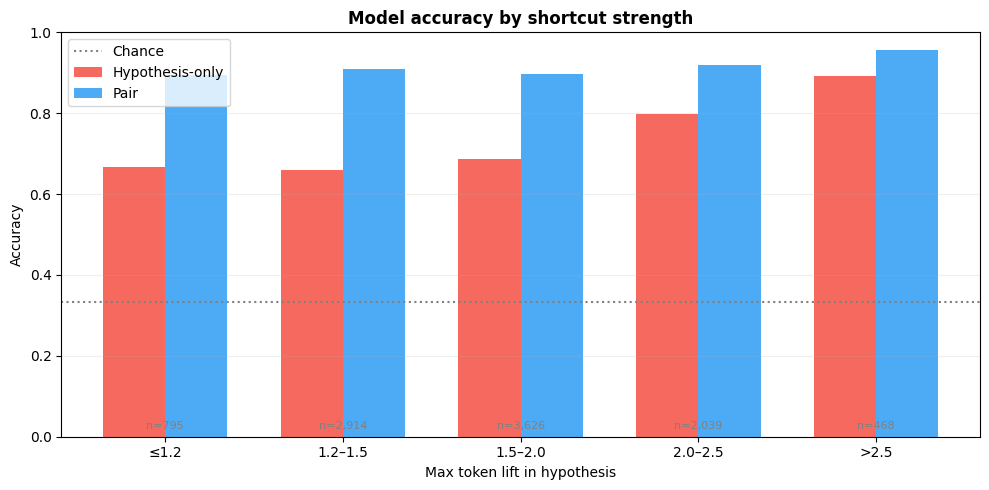

In [11]:
# Accuracy by lift bin
lift_bins   = [0, 1.2, 1.5, 2.0, 2.5, 10]
lift_labels = ['≤1.2', '1.2–1.5', '1.5–2.0', '2.0–2.5', '>2.5']
acc_lift = ss.accuracy_by_bin(pred_df, 'max_lift', lift_bins, lift_labels)

fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(acc_lift)); w = 0.35
ax.bar([i - w/2 for i in x], acc_lift['acc_hyp'],  width=w, label='Hypothesis-only', color='#F44336', alpha=0.8)
ax.bar([i + w/2 for i in x], acc_lift['acc_pair'], width=w, label='Pair', color='#2196F3', alpha=0.8)
ax.set_xticks(x); ax.set_xticklabels(acc_lift['bin'])
ax.set_ylabel('Accuracy'); ax.set_xlabel('Max token lift in hypothesis')
ax.set_title('Model accuracy by shortcut strength', fontsize=12, fontweight='bold')
ax.axhline(1/3, color='grey', linestyle=':', label='Chance')
for i, r in acc_lift.iterrows():
    ax.text(i, 0.02, f'n={int(r["n"]):,}', ha='center', fontsize=8, color='grey')
ax.legend(); ax.set_ylim(0, 1); ax.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.savefig(FIG_DIR / 'accuracy_by_lift.png', dpi=150, bbox_inches='tight')
plt.show()

The hypothesis-only model's accuracy rises monotonically with the maximum token lift in the hypothesis, from ~67% on examples with no shortcut tokens to ~89% on examples where the strongest token has lift > 2.5. This confirms that lexical shortcuts are a primary driver of hypothesis-only performance.

The pair model's accuracy is comparatively stable across bins and consistently higher, showing it does not rely on these shortcuts and instead leverages premise–hypothesis reasoning. The gap between the two models is widest in the low-lift regime — precisely where the hypothesis-only model loses its advantage and must rely on genuine inference (which it cannot do).

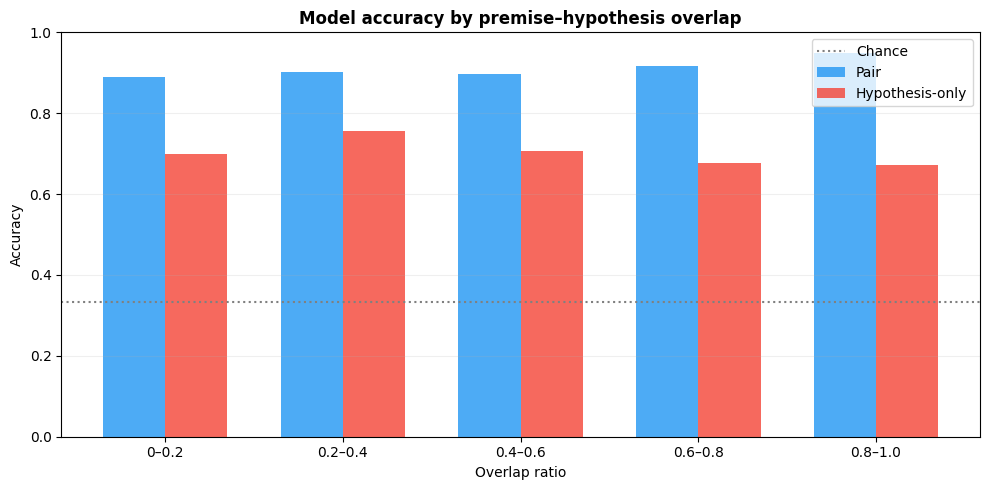

In [12]:
# Accuracy by overlap bin
ov_bins   = [0, 0.2, 0.4, 0.6, 0.8, 1.01]
ov_labels = ['0–0.2', '0.2–0.4', '0.4–0.6', '0.6–0.8', '0.8–1.0']
acc_ov = ss.accuracy_by_bin(pred_df, 'overlap_ratio', ov_bins, ov_labels)

fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(acc_ov)); w = 0.35
ax.bar([i - w/2 for i in x], acc_ov['acc_pair'], width=w, label='Pair', color='#2196F3', alpha=0.8)
ax.bar([i + w/2 for i in x], acc_ov['acc_hyp'],  width=w, label='Hypothesis-only', color='#F44336', alpha=0.8)
ax.set_xticks(x); ax.set_xticklabels(acc_ov['bin'])
ax.set_ylabel('Accuracy'); ax.set_xlabel('Overlap ratio')
ax.set_title('Model accuracy by premise–hypothesis overlap', fontsize=12, fontweight='bold')
ax.axhline(1/3, color='grey', linestyle=':', label='Chance')
ax.legend(); ax.set_ylim(0, 1); ax.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.savefig(FIG_DIR / 'accuracy_by_overlap.png', dpi=150, bbox_inches='tight')
plt.show()

The overlap ratio plot reveals the complementary structural shortcut. The **pair model** benefits strongly from high overlap (entailment signal): accuracy climbs from ~86% at low overlap to ~95% at overlap > 0.8 as it uses word matching as a proxy for entailment. The **hypothesis-only model** shows a flatter profile — it cannot use overlap at all (it never sees the premise), so its performance in the high-overlap bins reflects residual lexical shortcuts (entailment tokens like *outdoors*, *sport*) rather than structural reasoning.

Together, the two plots show that the pair model exploits both lexical and structural shortcuts on top of genuine reasoning, while the hypothesis-only model is limited to lexical ones.

In [13]:
# Agreement analysis
summary, profiles = ss.agreement_analysis(pred_df)

print('Model agreement:\n')
for _, r in summary.iterrows():
    print(f'  {r["category"]:20s}  {int(r["count"]):5,}  ({r["pct"]:.1%})')

print(f'\nFeature profiles:\n')
print(profiles.to_string(index=False, float_format='{:.3f}'.format))

Model agreement:

  both_correct          6,731  (68.4%)
  only_pair             2,205  (22.4%)
  only_hyp                255  (2.6%)
  both_wrong              651  (6.6%)

Feature profiles:

    category  mean_lift  mean_overlap  mean_hyp_len
both_correct      1.735         0.505         8.080
   only_pair      1.589         0.547         8.286
    only_hyp      1.665         0.492         8.671
  both_wrong      1.631         0.471         8.573


### Interpretation

The agreement breakdown reveals four qualitatively different example types:

- **Both correct (68.4%)** — examples where shortcuts are sufficient for the hypothesis-only model and the pair model agrees. These are the "easy" examples where shortcut-based reasoning and genuine NLI reasoning coincide.
- **Only pair correct (22.4%)** — the most informative category: examples where the hypothesis-only model fails, indicating the hypothesis does not contain sufficient shortcut signal. The pair model succeeds by using the premise. This is the regime where genuine NLI is necessary.
- **Only hypothesis-only correct (2.6%)** — rare cases where the hypothesis-only model gets lucky on a shortcut while the pair model is misled, perhaps by misleading premise content.
- **Both wrong (6.6%)** — hard examples that defeat both models, likely requiring world knowledge or pragmatic reasoning beyond what either model has learned.

The feature profiles confirm that the *only_pair* examples have slightly **lower max lift** (1.59 vs. 1.74 for both_correct), validating that shortcut strength is lower where the hypothesis-only model struggles.

## 4. Synthesis

| Source                 | Accuracy | Delta     |
|------------------------|----------|-----------|
| Chance                 | 33.3%    | —         |
| + Structural shortcuts | 49.0%    | +15.7 pp  |
| + All hypothesis cues  | 71.0%    | +22.0 pp  |
| + Premise reasoning    | 90.8%    | +19.8 pp  |

**~66% of above-chance performance is attributable to shortcuts, not semantic reasoning.**

The hypothesis-only model's accuracy scales directly with the lexical shortcut strength
(lift): from 66.8% on examples without shortcuts to 89.1% on examples with strong shortcuts.
The pair model additionally exploits premise–hypothesis overlap (89% → 94.8%).

These findings motivate Phase 4: constructing anti-shortcut evaluation splits
that neutralize the identified lexical and structural cues.